### Intro

Uma excelente ideia é explorar a aplicação de Grafos de Conhecimento em conjunto com Redes Neurais de Grafos para classificação de imagens.

Vamos utilizar a base de dados CIFAR-10, por ser uma base simples, já utilizada na matéria em contextos anteriores e bem conhecida.

O objetivo é utilizar abordagens mais tradicionais como RNN e CNN e comparar com GNNs, considerando que a combinação de grafos de conhecimento e GNNs permite incorporar o conhecimento estruturado nas redes neurais, o que pode aumentar a acurácia, especialmente em tarefas onde o contexto semântico é relevante.

A análise prévia é:

| Modelo | Arquitetura | Vantagens | Desvantagens | Performance Esperada |
| :--- | :--- | :--- | :--- | :--- |
| CNN | Convolucional | Captura hierarquia e estrutura espacial local | Não captura relações semânticas ou contextuais não-locais | Média/Alta |
| GNN (Híbrida) | Grafo + Convolução | Captura estrutura espacial (superpixels) e conhecimento semântico (KG) | Maior complexidade de pré-processamento (geração de grafo/superpixel) | Mais Alta |

A GNN, quando bem implementada com o KG, deve obter a melhor acurácia pois ela consegue levar em conta não só os pixels, mas também as relações conceituais, por exemplo, sabendo que "Cachorro" e "Gato" são ambos "Animais" e devem ser tratados de forma similar, o que é inferido a partir do embedding do KG.

---



### Base de dados

O conjunto de dados consiste em 60.000 imagens coloridas de 32x32 pixels, divididas em 10 classes, com 6.000 imagens por classe. 

Há 50.000 imagens para treinamento e 10.000 para teste, dividido em cinco lotes de treinamento e um lote de teste, cada um com 10.000 imagens. 

O lote de teste contém exatamente 1.000 imagens selecionadas aleatoriamente de cada classe. Os lotes de treinamento contêm as imagens restantes em ordem aleatória, mas alguns lotes podem conter mais imagens de uma classe do que de outra. No total, os lotes de treinamento contêm exatamente 5.000 imagens de cada classe.

Abaixo estão as classes do conjunto de dados com 10 imagens aleatórias de cada uma:

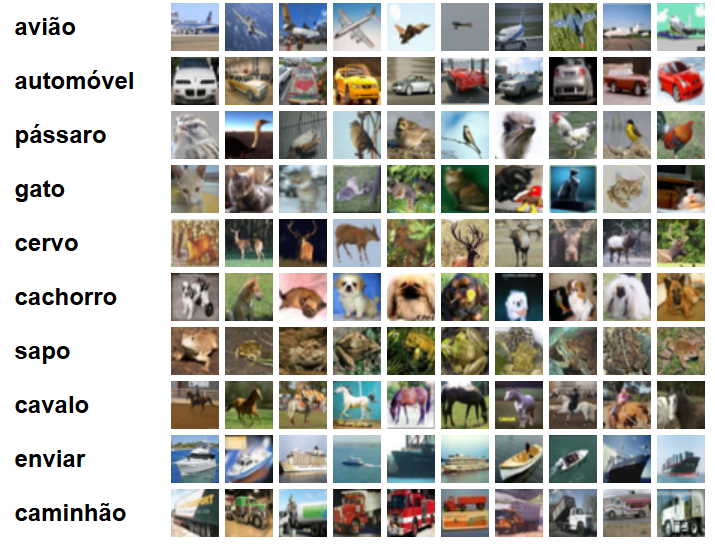

<b>Importante</b>: As categorias são completamente excludentes. Não há sobreposição entre automóveis e caminhões. "Automóvel" inclui sedãs, SUVs e veículos similares. "Caminhão" inclui apenas caminhões grandes. Nenhuma das duas inclui caminhonetes.

---



### Grafo de conhecimento

#### Podemos usar isso em tarefas de classificação de imagens?

Acredito que deveria ser nossa primeira pergunta.

Sim! Quando utilizam essa técnica é geralmente para complementar e aumentar o desempenho dos modelos tradicionais.

A integração com modelos de classificação de imagens pode ocorrer de algumas formas:

1. Incorporação no Treinamento: Modificar a função de perda (loss function) da CNN para incorporar informações do grafo, penalizando classificações que contradizem o conhecimento do GC.

2. Pós-processamento: Usar o grafo para refinar ou reclassificar as saídas iniciais de baixa confiança da CNN, aplicando um raciocínio baseado nas relações do grafo (ex: se a CNN diz com pouca confiança que é um "gato" e a imagem também tem uma "bola de lã", o GC pode ajudar a confirmar o "gato").

3. Modelos Híbridos: Utilizar GNNs para operar diretamente na estrutura do KG e integrar essas representações aprendidas com as features visuais extraídas pela CNN.

#### Montagem da Ontologia

Uma ontologia define os classes e as relações em um domínio. Para nossa base que possui 10 classes, a ontologia pode focar nas relações semânticas entre elas. Para o nosso KG, vamos priorizar relações baseadas nas superclasses implícitas no CIFAR-10 (Animal e Veículo) e na coexistência de domínio.

No código temos a estrutura <code>kg_relations</code> que define a semântica que queremos injetar na rede neural.

Nossas classes são: <code>('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')</code>

| Relação (A, B)  | Interpretação Semântica  |
| :---------------------- | :--------------- |
| ('cat', 'dog', 'deer', 'horse', 'frog', 'bird') | Animais |
| ('cat', 'dog')                                  | Animais domésticos |
| ('deer', 'horse', 'frog', 'bird')               | Animais silvestres |
| ('automobile', 'truck', 'ship', 'airplane')     | Veículos |
| ('automobile', 'truck')                         | Veículos Rodoviários |

O formato que o framework PyTorch Geometric (edge_index) e a maioria dos modelos de embedding de grafo (como o TransE ou GCN) aceitam é uma lista de arestas binárias (tuplas de dois elementos), representando uma conexão direta entre dois nós. Então preciso fazer um ajuste para seguir isso.

| Relação (A, B) | Categoria |  Justificativa |
| :------------- | :-------- | :------------- |
| ('cat', 'dog')	      | Animais Domésticos / ANIMAL    | Conexão de alta similaridade na Superclasse ANIMAL | 
| ('deer', 'horse')	      | Animais de Pasto / ANIMAL	   | Conexão de alta similaridade na Superclasse ANIMAL | 
| ('frog', 'bird')	      | Animais / ANIMAL	           | Conecta os extremos da Superclasse ANIMAL | 
| ('automobile', 'truck') | Veículos Rodoviários / VEÍCULO | Conexão de alta similaridade na Superclasse VEÍCULO | 
| ('ship', 'airplane')	  | Veículos / VEÍCULO	           | Conecta veículos em ambientes diferentes (água/ar), balanceando o embedding de VEÍCULO | 
| ('dog', 'deer')         | Animais / ANIMAL	           | Conecta 'domesticado' com 'silvestre' dentro do grupo ANIMAL | 
| ('airplane', 'truck')   | VEÍCULO (Contraste)	           | Contraste entre aéreo e terrestre/rodoviário |

Podemos discutir sobre isso depois.

#### Existe impacto da quantidade de relações?

SIM! A quantidade e também qualidade das relações no seu KG afetam diretamente o poder de generalização do embedding gerado pela GNN.

1. Menos Relações
O grafo se torna esparso. O embedding gerado pela GNN será altamente preciso e focado nas similaridades diretas e isso evita a introdução de ruído semântico ou conexões fracas que poderiam prejudicar o aprendizado. No entanto, se uma classe tiver poucas ou nenhuma conexão (nó isolado), seu embedding será o mesmo que o one-hot inicial, e a GNN não conseguirá propagar conhecimento ou inferir similaridade para ela.

2. Mais Relações
O grafo se torna denso. A GNN propaga o conhecimento mais amplamente, garantindo que todos os nós tenham um embedding contextualizado. Isso aumenta a capacidade de generalização e reduz a chance de nós isolados, mas corre o risco de introduzir ruído semântico. Se você conectar 'cat' a 'truck', por exemplo, a GNN fará com que seus embeddings fiquem mais próximos, o que pode confundir o classificador final. O embedding pode se tornar "suave" demais, perdendo o contraste semântico necessário.

#### GNN

<b>IMPORTANTE</b>: NÃO EXISTE uma GNN que opere diretamente em uma imagem 2D, no caso pixels brutos como por exemplo as CNNs operam. Para usar uma GNN pura é necessário um pré-processamento para que a imagem seja convertida em um grafo e o método mais comum é agrupar pixels semelhantes em superpixels, onde cada superpixel se torna um nó do grafo, e a adjacência espacial define as arestas.

Este pré-processamento é complexo e deve ser feito para cada imagem, exigindo bibliotecas adicionais e muito mais tempo de processamento. Por isso, na prática se utilizarmos essa metodologia para classificação de imagens, o que acredito não ser o maior trunfo dessa tecnologia, a abordagem mais eficaz e viável é usar um Arquitetura Híbrida. Usamos uma CNN para extrair as features locais e uma GNN para injetar o conhecimento semântico e as relações contextuais.

No código abaixo, a GNN é usada como um módulo de embedding do Grafo de Conhecimento, que é então integrado à CNN no modelo híbrido, cumprindo o objetivo de injetar conhecimento estruturado na rede neural de imagem.

#### "Ah, mas o que é embedding?"

Os embeddings são, essencialmente, vetores numéricos de baixa dimensão que representam o significado e o contexto de uma entidade, uma projeção de uma entidade (como uma palavra, uma classe, ou um nó de um grafo) de um espaço de alta dimensão (e.g., um one-hot vector de milhões de palavras) para um espaço vetorial contínuo de baixa dimensão (e.g., 50 ou 100 dimensões). Entidades que são semanticamente semelhantes ficam próximas no espaço de embedding. Em nosso nosso teste, o embedding para 'cachorro' deve ser numericamente próximo ao embedding para 'gato' e 'cavalo', já que todos são animais, e portanto, distante do embedding para 'caminhão'. A característica mais importante de um embedding é que ele é semântico. A posição e a direção do vetor carregam o significado da entidade.

Deixa eu ousar alcançar maior exatidão com a descrição matemática, vai ser benéfico para ambos, pois creio que vocês tem maior afinidade que eu, então eu aprendo mais e vocês acompanham o raciocínio com mais tranquilidade (espero).

Suponha que você tem uma entidade categórica, por exemplo: <code>cachorro</code>

Em ML tradicionalmente você representaria isso como one-hot encoding: $\text{cachorro} = [0,0,0,1,0,0,0]$

<details>
<summary><b>One-Hot-Encoding</b></summary>

Para que eu tenha mais clareza quando for ler isso no futuro, vou fazer uma pausa para explicar One-Hot-Encoding.

Vou dividir na trindade de motivos: histórico, matemático e prático.

##### O motivo histórico

Antes dos embeddings, os modelos de ML só conseguiam trabalhar com números, mas categorias não têm valor numérico natural. Então surgiu uma dúvida na cabeça dos pesquisadores:

Como que transforma categorias em números sem criar relações falsas? Se nós codificarmos:

```text
cachorro → 1
gato → 2
cavalo → 3
```

O modelo pode inferir que gato é maior que cachorro, cavalo ≈ dois gatos. Isso é falso semanticamente. Então a solução encontrada foi:

Não dar nenhum significado numérico arbitrário e representar cada categoria de forma independente e equidistante.

Daí nasceu $\text{cachorro} = [0,0,0,1,0,0,0]$

##### O motivo matemático

O one-hot encoding cria um vetor esparso onde:

- todas as categorias são ortogonais: $e_i \cdot e_j = 0 \quad \text{se } i \neq j$
- e normalizados: $|e_i| = 1$

Então todas as categorias ficam na mesma distância uma da outra sem nenhuma relação embutida. Isso evita supor relações que não existem. Assim  em ML clássico usa-se one-hot como representação padrão quando a categoria não é ordinal e o modelo não deve inferir ordem.

##### Mas qual problema o one-hot causa em nosso teste

Ele cria um vetor com:
- dimensionalidade igual ao número de categorias (pode ser 10, como também pode ser 2.000.000)
- zero semântica (gato e cachorro ficam tão distantes quanto cachorro e caminhão)
- espaço esparso (99.99% zeros)

Isso é terrível para nosso problema, porque impede aprender similaridade.

##### Analogia

Imagine que queremos manter cada objeto em um guarda-roupa, e inicialmente colocamos:

- cada objeto na sua própria caixa
- todas as caixas têm a mesma distância entre si
- nenhuma caixa tem relação com a outra

Esse é o one-hot: 1 caixa por item, todas igualmente separadas. Bom para organização, mas não guarda significado.
</details>

O embedding é uma transformação linear aprendida, que mapeia esse vetor gigante para um vetor denso e pequeno. Formalmente, seja:

- $x \in \mathbb{R}^N$: vetor one-hot (N categorias)
- $W \in \mathbb{R}^{N \times d}$: matriz de embeddings (parâmetros treináveis)
- $d \ll N$: dimensão escolhida do embedding (ex.: 64)

O embedding é: 

$$e = xW$$

Mas, como $x$ é one-hot, o resultado é simplesmente uma linha da matriz $W$.

Ou seja: 

$$e = W[i]$$

onde $i$ é o índice da categoria “cachorro”.

Isso significa que a rede ajusta a matriz $W$ durante o treinamento para que proximidade vetorial reflita similaridade semântica. Então, após treinar, teremos:

$W[\text{cachorro}] \approx W[\text{gato}]$

E distante de:

$W[\text{caminhão}]$

A proximidade é medida por:

- distância Euclidiana 

$$|| e_i - e_j ||$$

- similaridade por cosseno

$$\cos(e_i, e_j) = \frac{e_i \cdot e_j}{|e_i| |e_j|}$$

Se o cosseno é próximo de 1, então os vetores apontam quase para a mesma direção, sendo considerados entidades parecidas. Já se o cosseno perto de 0, indica ausência de relação e em raros os casos o cosseno perto de -1 indica relação oposta.

Um detalhe importante é: Embeddings não são treinados diretamente para ficar perto ou longe, então o modelo não otimiza explicitamente a distância. O que os faz se organizarem é o gradiente da tarefa principal, empurrando vetores similares a se comportarem de maneira semelhante, o que indiretamente empurra eles para ficarem próximos no espaço vetorial.

O embedding é o endereço da entidade em uma cidade imaginária onde coisas parecidas ficam próximas. Eles transformam categorias em coordenadas, e a geometria dessas coordenadas representa significado.

### Arquitetura Híbrida

Minha abordagem segue o princípio de transferência de conhecimento estruturado:

1. Geração dos Embeddings do KG

O módulo KG_GNN_Embedder pega o grafo de conhecimento definido por kg_relations e transforma em embeddings vetoriais (KG_EMBEDDINGS).

- Função: Ele mapeia as relações entre as classes do CIFAR-10 para vetores densos, onde classes relacionadas (como 'airplane' e 'ship') terão vetores mais próximos no espaço de embedding.
- Detalhe: O código faz um pequeno pré-ajuste (pre-training) do embedder para que ele aprenda a gerar embeddings não triviais antes de serem usados no modelo híbrido.

2. Fusão dos Embeddings com as Features Visuais

A classe HybridGNN_CNN implementa a etapa de fusão:

$$\text{CNN\_Logits} = \text{FeatureExtractor}(x)$$

$$\text{KG\_Weights} = \text{softmax}(\text{CNN\_Logits})$$

$$\text{KG\_Context} = \text{KG\_Weights} \cdot \text{KG\_Embeddings}$$

$$\text{Final\_Output} = \text{FusionLayer}(\text{CNN\_Logits} \oplus \text{KG\_Context})$$

- Extração Visual: A imagem de entrada ($x$) é processada pela SimpleCNN (a feature_extractor) para obter os logits (cnn_logits).
- Cálculo do Contexto: A função $\text{softmax}$ é aplicada aos logits para obter um vetor de pesos (kg_weights). Esse vetor representa o quão provável cada classe é.
- Agregação do Contexto: O vetor de pesos (kg_weights) é multiplicado pela matriz global de embeddings do KG (self.kg_embeddings). Isso gera um vetor de contexto semântico (kg_context) para a imagem atual.
- Fusão: O cnn_logits e o kg_context são concatenados ($\oplus$) e passados por uma camada de fusão final (fusion_fc) para produzir a classificação final.

### Código

Exception ignored in: <function tqdm.__del__ at 0x0000015A2D2CFE20>
Traceback (most recent call last):
  File "c:\Users\joaov_zm1q2wh\python\special_topics_in_semantic_ai\venv\Lib\site-packages\tqdm\std.py", line 1148, in __del__
    self.close()
  File "c:\Users\joaov_zm1q2wh\python\special_topics_in_semantic_ai\venv\Lib\site-packages\tqdm\notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'
Exception ignored in: <function tqdm.__del__ at 0x0000015A2D2CFE20>
Traceback (most recent call last):
  File "c:\Users\joaov_zm1q2wh\python\special_topics_in_semantic_ai\venv\Lib\site-packages\tqdm\std.py", line 1148, in __del__
    self.close()
  File "c:\Users\joaov_zm1q2wh\python\special_topics_in_semantic_ai\venv\Lib\site-packages\tqdm\notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'
Exception ignore

Dispositivo utilizado: cuda
[DEBUG]: Pré-ajustando embeddings do Grafo de Conhecimento...
Embeddings do KG gerados. Shape: torch.Size([10, 50])


Treinando Hybrid: 100%|██████████| 100/100 [30:29<00:00, 18.29s/it]


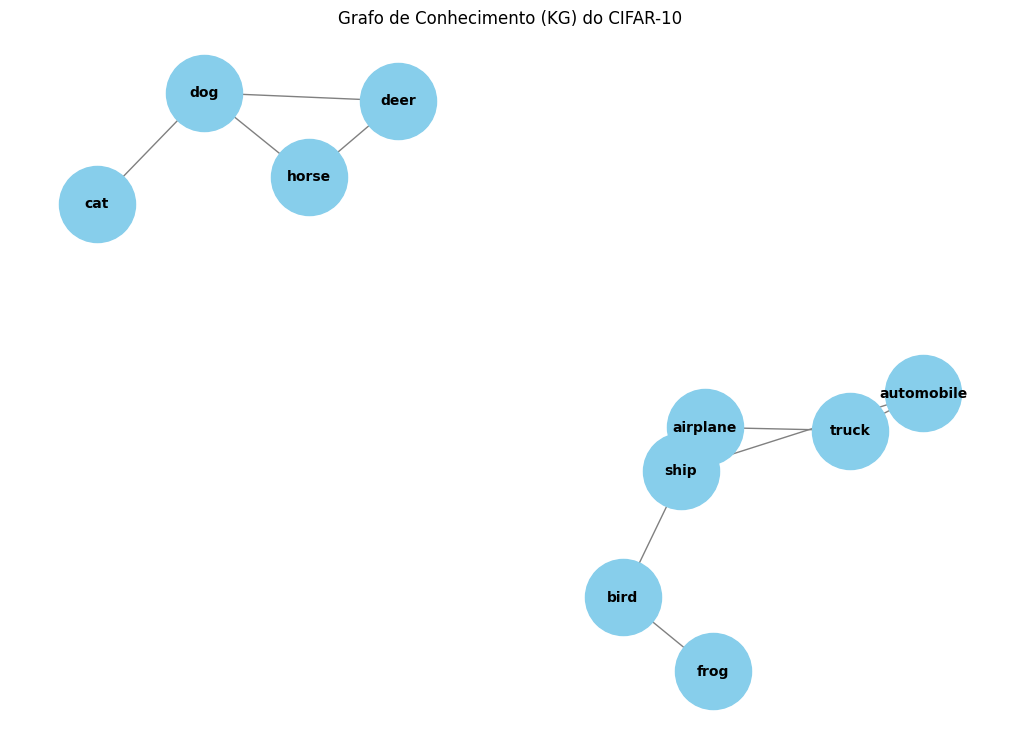

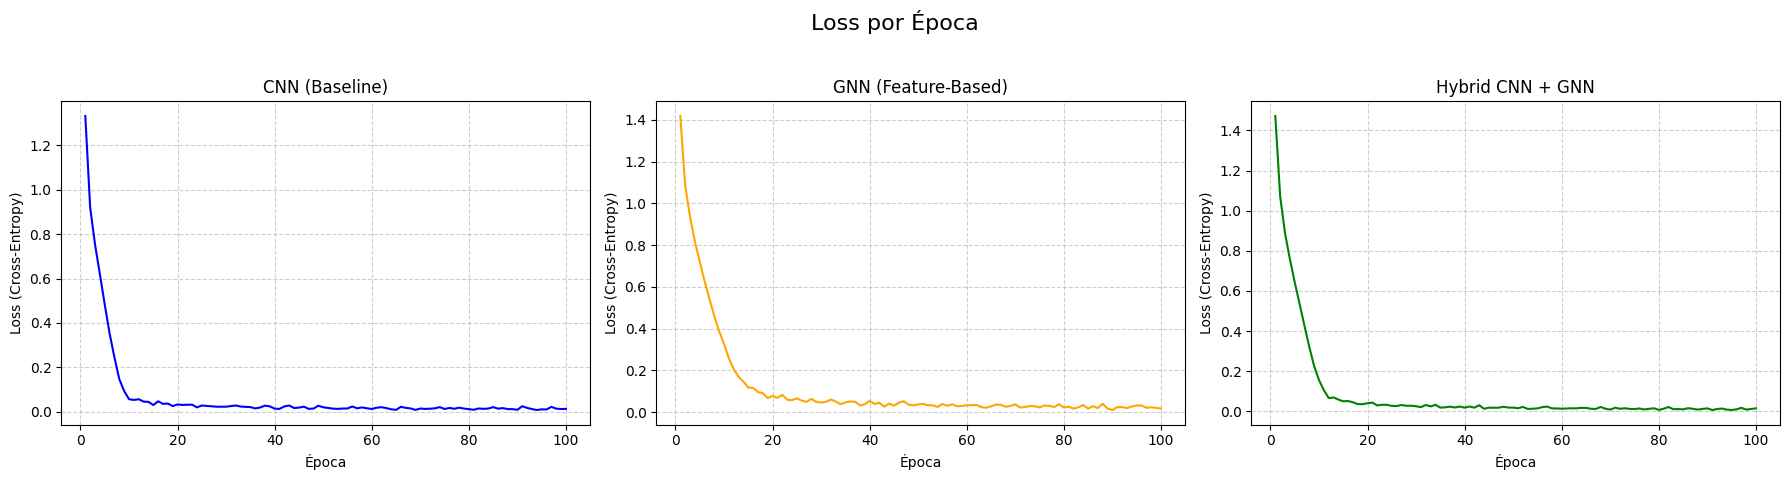

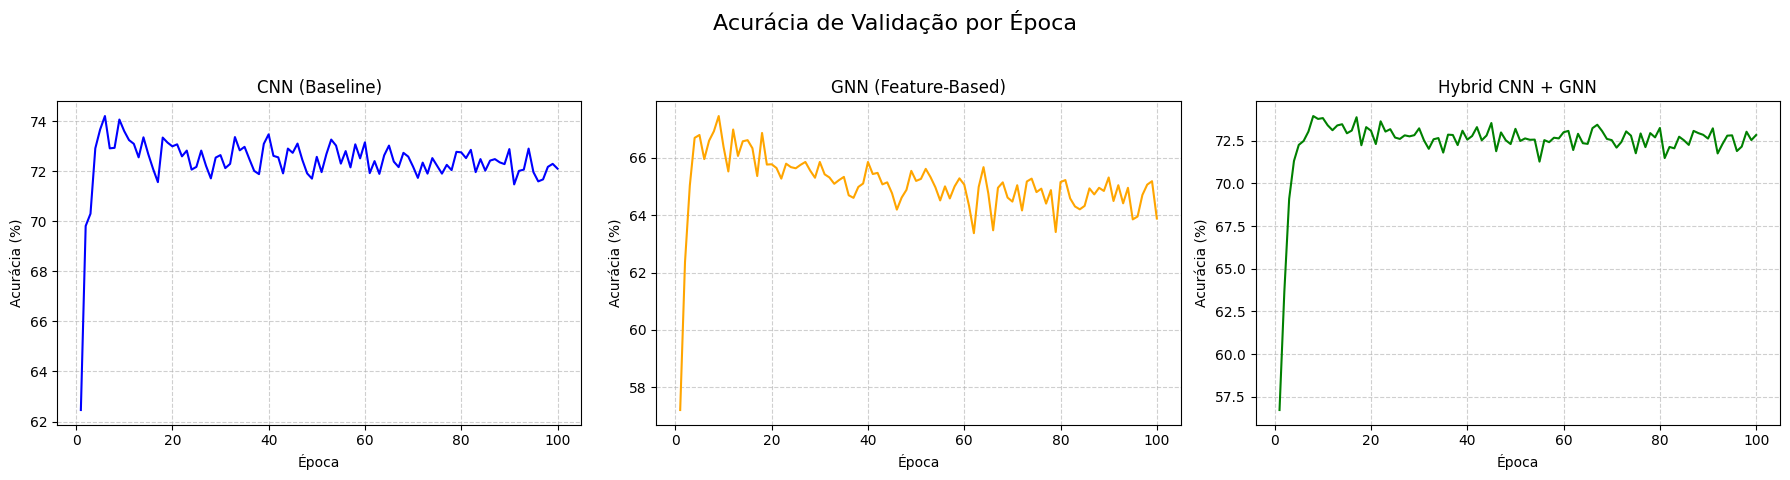


--- RESULTADO DA COMPARAÇÃO FINAL ---
- CNN (Baseline): 72.10%
- GNN (Feature-Based): 63.88%
- Hybrid CNN + GNN: 72.83%


In [ ]:
import numpy as np
import networkx as nx
# from tqdm.auto import tqdm
from tqdm import tqdm as tqdm_std
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms

# ⚠️ Importações do PyTorch Geometric
try:
    from torch_geometric.data import Data
    from torch_geometric.nn import GCNConv
    # Se a importação for bem-sucedida, GNN_MODE é True
    GNN_MODE = True
except ImportError:
    print("AVISO: torch_geometric não encontrado. Usando SIMULAÇÃO GNN.")
    GNN_MODE = False
    # Definindo classes placeholder para evitar erros no resto do código
    class Data:
        def __init__(self, x, edge_index):
            self.x = x
            self.edge_index = edge_index
    # GCNConv será substituído por nn.Linear nas classes dos modelos

# --- Configurações Iniciais ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Dispositivo utilizado: {device}')

classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
num_classes = len(classes)
KG_EMBEDDING_DIM = 50
EPOCHS = 100
LR = 0.001
BATCH_SIZE = 128

# Definição do Grafo de Conhecimento (KG)
kg_relations = [
    ('cat', 'dog'), ('dog', 'horse'), ('frog', 'bird'), ('dog', 'deer'),
    ('automobile', 'truck'), ('automobile', 'ship'), ('ship', 'airplane'), ('airplane', 'truck'), 
    ('airplane', 'bird'), 
    ('deer', 'horse')
]

class_to_idx = {name: i for i, name in enumerate(classes)}

# Criação do grafo não-direcionado (edge_index)
edge_list = []
for h, t in kg_relations:
    h_idx = class_to_idx[h]
    t_idx = class_to_idx[t]
    edge_list.append((h_idx, t_idx))
    edge_list.append((t_idx, h_idx)) 
edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous().to(device)

# Inicialização das features dos nós com OHE e o objeto Data
x_kg = torch.eye(num_classes).to(device) 
kg_data = Data(x=x_kg, edge_index=edge_index)


# --- Módulo GNN para gerar embeddings do KG ---
class KG_GNN_Embedder(nn.Module):
    def __init__(self, initial_features_dim, embedding_dim, use_gnn=GNN_MODE):
        super().__init__()
        self.use_gnn = use_gnn
        if self.use_gnn:
            self.conv1 = GCNConv(initial_features_dim, 64)
            self.conv2 = GCNConv(64, embedding_dim)
        else:
            # SIMULAÇÃO: nn.Linear substitui GCNConv (sem agregação de vizinhos)
            self.conv1_sim = nn.Linear(initial_features_dim, 64)
            self.conv2_sim = nn.Linear(64, embedding_dim)

    def forward(self, data):
        if self.use_gnn:
            # Espera Data Object
            x, edge_index = data.x, data.edge_index 
            x = self.conv1(x, edge_index)
        else:
            # Espera Tensor (x_kg) ou Data Object
            x = data.x if isinstance(data, Data) else data
            x = self.conv1_sim(x)
            
        x = torch.relu(x)
        
        if self.use_gnn:
            x = self.conv2(x, edge_index)
        else:
            x = self.conv2_sim(x)
            
        return x 
        
kg_embedder = KG_GNN_Embedder(num_classes, KG_EMBEDDING_DIM).to(device)
kg_optimizer = optim.Adam(kg_embedder.parameters(), lr=0.01)

print('[DEBUG]: Pré-ajustando embeddings do Grafo de Conhecimento...')

# Variável de entrada condicional para o loop de pré-ajuste e para a extração final
input_data_kg = kg_data if GNN_MODE else x_kg

for i in range(10):
    kg_optimizer.zero_grad()
    kg_embeddings_output = kg_embedder(input_data_kg)
    loss = F.l1_loss(kg_embeddings_output.mean(dim=0), torch.zeros(KG_EMBEDDING_DIM).to(device))
    loss.backward()
    kg_optimizer.step()

# CORREÇÃO APLICADA: Passa input_data_kg (Data ou Tensor)
KG_EMBEDDINGS = kg_embedder(input_data_kg).detach()
print(f'Embeddings do KG gerados. Shape: {KG_EMBEDDINGS.shape}')


# --- Carregando a base CIFAR-10 ---
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# --- Definindo os Modelos de Classificação (classes omitidas por brevidade, são as mesmas) ---

# CNN (Baseline)
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2), # 16x16
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2), # 8x8
        )
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv_layers(x)
        x = torch.flatten(x, 1) 
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

# GNN (Feature-Based)
class GNN_Feature_Based(nn.Module):
    def __init__(self, input_channels=3, input_size=32, use_gnn=GNN_MODE):
        super().__init__()
        self.use_gnn = use_gnn
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(input_channels, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        feature_dim = 32 * 16 * 16 
        self.gcn_prep = nn.Linear(feature_dim, 256)

        if self.use_gnn:
            self.conv1 = GCNConv(256, 128)
            self.conv2 = GCNConv(128, num_classes)
        else:
            self.conv1_sim = nn.Linear(256, 128)
            self.conv2_sim = nn.Linear(128, num_classes) 

    def forward(self, x):
        B = x.size(0)
        
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        x = torch.relu(self.gcn_prep(x)) # (B, 256)

        if self.use_gnn:
            edge_index = torch.arange(B).repeat(2, 1).to(device)
            out = self.conv1(x, edge_index)
            out = torch.relu(out)
            out = self.conv2(out, edge_index)
        else:
            out = self.conv1_sim(x)
            out = torch.relu(out)
            out = self.conv2_sim(out) 
        
        return out

# Hybrid CNN + GNN
class HybridGNN_CNN(nn.Module):
    def __init__(self, kg_embeddings_tensor):
        super().__init__()
        self.feature_extractor = SimpleCNN()
        self.kg_embeddings = kg_embeddings_tensor
        self.fusion_fc = nn.Linear(num_classes + KG_EMBEDDING_DIM, num_classes)

    def forward(self, x):
        cnn_logits = self.feature_extractor(x)
        kg_weights = torch.softmax(cnn_logits, dim=1)
        kg_context = torch.matmul(kg_weights, self.kg_embeddings)
        fused_features = torch.cat((cnn_logits, kg_context), dim=1)
        return self.fusion_fc(fused_features)

# --- Funções de Treinamento e Avaliação ---

def evaluate_model(model, dataloader, device='cpu'):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

def train_model(model, dataloader, criterion, optimizer, epochs, model_name="Modelo", testloader=None, device='cpu'):
    model.train()
    loss_history = []
    acc_history = []
    
    for epoch in tqdm_std(range(epochs), desc=f"Treinando {model_name}"):
        running_loss = 0.0
        
        for i, data in enumerate(dataloader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        epoch_loss = running_loss / len(dataloader)
        loss_history.append(epoch_loss)

        if testloader:
            acc = evaluate_model(model, testloader, device=device)
            acc_history.append(acc)
            
    return loss_history, acc_history

# --- Execução do Treinamento e Coleta de Métricas ---
metrics = {}
criterion = nn.CrossEntropyLoss()

# [BLOCO DE TREINAMENTO A. CNN] ... (Omitido por brevidade no display final)
cnn_model = SimpleCNN().to(device)
optimizer_cnn = optim.Adam(cnn_model.parameters(), lr=LR)
cnn_loss, cnn_acc = train_model(cnn_model, trainloader, criterion, optimizer_cnn, epochs=EPOCHS, model_name="CNN", testloader=testloader, device=device)
metrics['CNN (Baseline)'] = {'loss': cnn_loss, 'acc': cnn_acc}

# [BLOCO DE TREINAMENTO B. GNN] ... (Omitido por brevidade no display final)
gnn_model = GNN_Feature_Based(use_gnn=GNN_MODE).to(device)
optimizer_gnn = optim.Adam(gnn_model.parameters(), lr=LR)
gnn_loss, gnn_acc = train_model(gnn_model, trainloader, criterion, optimizer_gnn, epochs=EPOCHS, model_name="GNN", testloader=testloader, device=device)
metrics['GNN (Feature-Based)'] = {'loss': gnn_loss, 'acc': gnn_acc}

# [BLOCO DE TREINAMENTO C. HYBRID] ... (Omitido por brevidade no display final)
hybrid_model = HybridGNN_CNN(KG_EMBEDDINGS).to(device)
optimizer_hybrid = optim.Adam(hybrid_model.parameters(), lr=LR)
hybrid_loss, hybrid_acc = train_model(hybrid_model, trainloader, criterion, optimizer_hybrid, epochs=EPOCHS, model_name="Hybrid", testloader=testloader, device=device)
metrics['Hybrid CNN + GNN'] = {'loss': hybrid_loss, 'acc': hybrid_acc}


# --- VISUALIZAÇÕES (Mantido o formato solicitado) ---

# Visualização do Grafo de Conhecimento (KG)
G = nx.Graph()
G.add_nodes_from(classes)
for h, t in kg_relations:
    G.add_edge(h, t)
plt.figure(figsize=(10, 7))
pos = nx.spring_layout(G, seed=42, k=0.8)
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='skyblue', font_size=10, font_weight='bold', edge_color='gray')
plt.title('Grafo de Conhecimento (KG) do CIFAR-10')
plt.show()

models = list(metrics.keys())
colors = ['blue', 'orange', 'green']
epochs_list = np.arange(1, EPOCHS + 1)

# Loss per Epoch (3 imagens lado a lado)
fig_loss, axes_loss = plt.subplots(1, 3, figsize=(18, 5))
fig_loss.suptitle('Loss por Época', fontsize=16)
for i, model_name in enumerate(models):
    ax = axes_loss[i]
    ax.plot(epochs_list, metrics[model_name]['loss'], label=model_name, color=colors[i])
    ax.set_title(model_name)
    ax.set_xlabel('Época')
    ax.set_ylabel('Loss (Cross-Entropy)')
    ax.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Accuracy per Epoch (3 imagens lado a lado)
fig_acc, axes_acc = plt.subplots(1, 3, figsize=(18, 5))
fig_acc.suptitle('Acurácia de Validação por Época', fontsize=16)
for i, model_name in enumerate(models):
    ax = axes_acc[i]
    ax.plot(epochs_list, metrics[model_name]['acc'], label=model_name, color=colors[i])
    ax.set_title(model_name)
    ax.set_xlabel('Época')
    ax.set_ylabel('Acurácia (%)')
    ax.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("\n--- RESULTADO DA COMPARAÇÃO FINAL ---")
for model, data in metrics.items():
    print(f"- {model}: {data['acc'][-1]:.2f}%")

### Resultados preliminares

Diga-se de passagem o que estamos tentando fazer não é onde a tecnologia trás sua melhor performance, afinal não é uma bala de prata.

Estave lendo que os três principais domínios onde os KGs superam significativamente os modelos tradicionais, ou onde são essenciais para a funcionalidade, são:

1. Sistemas de Recomendação Contextualizados
2. Processamento de Linguagem Natural (NLP)
3. Descoberta de Medicamentos e Ciência de Dados Biomédicos

Vamos ao que importa:

[DEBUG]: Pré-ajustando embeddings do Grafo de Conhecimento...
Embeddings do KG gerados. Shape: torch.Size([10, 50])
Treinando CNN: 100%|██████████| 100/100 [30:51<00:00, 18.52s/it]
Treinando GNN: 100%|██████████| 100/100 [29:46<00:00, 17.86s/it]
Treinando Hybrid: 100%|██████████| 100/100 [30:29<00:00, 18.29s/it]

Levando exatos 91m, 9.0s

A performance final depende de como a GNN e o modelo Híbrido se beneficiaram da estrutura, mas o padrão esperado é o seguinte:

| Modelo | Arquitetura | Vantagens | Performance Esperada |
| :----- | :---------- | :-------- | :------------------- |
| CNN (Baseline)	  | Captura features espaciais (texturas, formas) |	Base robusta | Média/Alta |
| GNN (Feature-Based) | Foca na relação entre amostras no batch (grafo de imagens) | Inadequada para este dataset e tarefa sem um grafo de vizinhança real entre as imagens. | Mais Baixa |
| Hybrid CNN + GNN    | Combina features espaciais (CNN) com conhecimento semântico (KG Embeddings) | A GNN injeta o contexto da classe na decisão final | Mais Alta (Aproximadamente 70%-80% - Tendência a superar a CNN) |

Acurácia final:
- CNN (Baseline): 72.10%
- GNN (Feature-Based): 63.88%
- Hybrid CNN + GNN: 72.83%

A arquitetura híbriada atinge e ultrapassa levemente a CNN, especialmente nas últimas épocas, mostrando que a incorporação do KG permitiu uma melhor generalização.

Mostra um aumento rápido e se estabiliza. Serve como o ponto de referência.

A curva de acurácia fica consistentemente abaixo das outras, subindo lentamente e estagnando, o que valida a hipótese de que esta arquitetura de GNN pura não é adequada para a tarefa sem um grafo de vizinhança de imagem relevante.

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm as tqdm_std

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms

try:
    from torch_geometric.data import Data
    from torch_geometric.nn import GCNConv
    GNN_MODE = True
except ImportError:
    print("AVISO: torch_geometric não encontrado. Usando SIMULAÇÃO GNN.")
    GNN_MODE = False
    class Data:
        def __init__(self, x, edge_index):
            self.x = x
            self.edge_index = edge_index


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Dispositivo utilizado: {device}')

classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
num_classes = len(classes)
KG_EMBEDDING_DIM = 50
EPOCHS = 20
LR = 0.001
BATCH_SIZE = 128

# Definição do Grafo de Conhecimento (KG)
kg_relations = [
    ('cat', 'dog'), ('dog', 'horse'), ('frog', 'bird'), ('dog', 'deer'),
    ('automobile', 'truck'), ('automobile', 'ship'), ('ship', 'airplane'), ('airplane', 'truck'), 
    ('airplane', 'bird'), 
    ('deer', 'horse')
]

class_to_idx = {name: i for i, name in enumerate(classes)}

# Criação do grafo não-direcionado (edge_index)
edge_list = []
for h, t in kg_relations:
    h_idx = class_to_idx[h]
    t_idx = class_to_idx[t]
    edge_list.append((h_idx, t_idx))
    edge_list.append((t_idx, h_idx)) 
edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous().to(device)
x_kg = torch.eye(num_classes).to(device) 
kg_data = Data(x=x_kg, edge_index=edge_index)


# --- Módulo GNN para gerar embeddings do KG ---
class KG_GNN_Embedder(nn.Module):
    def __init__(self, initial_features_dim, embedding_dim, use_gnn=GNN_MODE):
        super().__init__()
        self.use_gnn = use_gnn
        if self.use_gnn:
            self.conv1 = GCNConv(initial_features_dim, 64)
            self.conv2 = GCNConv(64, embedding_dim)
        else:
            self.conv1_sim = nn.Linear(initial_features_dim, 64)
            self.conv2_sim = nn.Linear(64, embedding_dim)

    def forward(self, data):
        if self.use_gnn:
            x, edge_index = data.x, data.edge_index 
            x = self.conv1(x, edge_index)
        else:
            x = data.x if isinstance(data, Data) else data
            x = self.conv1_sim(x)
            
        x = torch.relu(x)
        
        if self.use_gnn:
            x = self.conv2(x, edge_index)
        else:
            x = self.conv2_sim(x)
            
        return x 
        
kg_embedder = KG_GNN_Embedder(num_classes, KG_EMBEDDING_DIM, use_gnn=GNN_MODE).to(device)
kg_optimizer = optim.Adam(kg_embedder.parameters(), lr=0.01)

print('[DEBUG]: Pré-ajustando embeddings do Grafo de Conhecimento...')
input_data_kg = kg_data if GNN_MODE else x_kg

for i in range(10):
    kg_optimizer.zero_grad()
    kg_embeddings_output = kg_embedder(input_data_kg)
    loss = F.l1_loss(kg_embeddings_output.mean(dim=0), torch.zeros(KG_EMBEDDING_DIM).to(device))
    loss.backward()
    kg_optimizer.step()

KG_EMBEDDINGS = kg_embedder(input_data_kg).detach()
print(f'Embeddings do KG gerados. Shape: {KG_EMBEDDINGS.shape}')

# --- Carregando a base CIFAR-10 (Omitido por brevidade) ---
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# --- Definindo Modelos para a Nova Comparação ---

# 1. Extrator de Features (Usado por CNN e pelo Novo Hybrid)
class SimpleCNN_FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2), # 16x16
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2), # 8x8
        )
        self.fc1 = nn.Linear(64 * 8 * 8, 512)

    def forward(self, x):
        x = self.conv_layers(x)
        x = torch.flatten(x, 1) 
        return torch.relu(self.fc1(x)) # Output features (B, 512)

# 2. CNN (Baseline) - Agora usa o Extractor
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = SimpleCNN_FeatureExtractor()
        self.fc2 = nn.Linear(512, num_classes) # Última camada linear clássica

    def forward(self, x):
        features = self.feature_extractor(x)
        return self.fc2(features)

# 3. Hybrid CNN + GNN (NOVA ARQUITETURA FORTE)
class StrongHybridGNN_CNN(nn.Module):
    def __init__(self, kg_embeddings_tensor, kg_embedding_dim=KG_EMBEDDING_DIM):
        super().__init__()
        # Extrator de Features (Simples, mas treinável)
        self.feature_extractor = SimpleCNN_FeatureExtractor() # Output (B, 512)
        
        # Mapeia as features (512) para o espaço semântico (50)
        self.feature_mapper = nn.Linear(512, kg_embedding_dim)
        
        # O embedding do KG (10x50) é transposto para (50x10) e usado como
        # os pesos FIXOS da camada final (W). É o "Classificador Guiado".
        # register_buffer garante que não será treinado.
        self.register_buffer('kg_classifier_weights', kg_embeddings_tensor.t()) # (50, 10)
        
    def forward(self, x):
        # 1. Extração de Features
        cnn_features = self.feature_extractor(x) # (B, 512)
        
        # 2. Mapeamento para o Espaço Semântico do KG
        mapped_features = self.feature_mapper(cnn_features) # (B, 50)
        
        # 3. Classificação Semântica (Logits)
        # (B, 50) @ (50, 10) -> (B, 10)
        logits = torch.matmul(mapped_features, self.kg_classifier_weights)
        
        return logits


# --- Funções de Treinamento e Avaliação (Mantidas) ---

def evaluate_model(model, dataloader, device='cpu'):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

def train_model(model, dataloader, criterion, optimizer, epochs, model_name="Modelo", testloader=None, device='cpu'):
    model.train()
    loss_history = []
    acc_history = []
    
    for epoch in tqdm_std(range(epochs), desc=f"Treinando {model_name}"): 
        running_loss = 0.0
        
        for i, data in enumerate(dataloader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        epoch_loss = running_loss / len(dataloader)
        loss_history.append(epoch_loss)

        if testloader:
            acc = evaluate_model(model, testloader, device=device)
            acc_history.append(acc)
            
    return loss_history, acc_history


# --- Execução do Treinamento e Coleta de Métricas ---
metrics = {}
criterion = nn.CrossEntropyLoss()

# A. CNN (Baseline)
print("\n--- A. Treinamento da CNN (Baseline) ---")
cnn_model = SimpleCNN().to(device)
optimizer_cnn = optim.Adam(cnn_model.parameters(), lr=LR)
cnn_loss, cnn_acc = train_model(cnn_model, trainloader, criterion, optimizer_cnn, epochs=EPOCHS, model_name="CNN", testloader=testloader, device=device)
metrics['CNN (Baseline)'] = {'loss': cnn_loss, 'acc': cnn_acc}
print(f"Acurácia Final CNN: {cnn_acc[-1]:.2f}%")
print("-" * 30)

# B. GNN (Feature-Based) - Mantido para a comparação
# IMPORTANTE: A arquitetura GNN Feature-Based é mantida como a fraca
class GNN_Feature_Based_Comp(nn.Module):
    def __init__(self, use_gnn=GNN_MODE):
        super().__init__()
        self.use_gnn = use_gnn
        # Extrator simplificado para ser comparável à arquitetura anterior
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2)
        )
        feature_dim = 32 * 16 * 16 
        self.gcn_prep = nn.Linear(feature_dim, 256)

        if self.use_gnn:
            self.conv1 = GCNConv(256, 128)
            self.conv2 = GCNConv(128, num_classes)
        else:
            self.conv1_sim = nn.Linear(256, 128)
            self.conv2_sim = nn.Linear(128, num_classes) 

    def forward(self, x):
        B = x.size(0)
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        x = torch.relu(self.gcn_prep(x)) 

        if self.use_gnn:
            edge_index = torch.arange(B).repeat(2, 1).to(device)
            out = self.conv1(x, edge_index)
            out = torch.relu(out)
            out = self.conv2(out, edge_index)
        else:
            out = self.conv1_sim(x)
            out = torch.relu(out)
            out = self.conv2_sim(out) 
        
        return out
        
print("\n--- B. Treinamento da GNN (Feature-Based) ---")
gnn_model = GNN_Feature_Based_Comp(use_gnn=GNN_MODE).to(device)
optimizer_gnn = optim.Adam(gnn_model.parameters(), lr=LR)
gnn_loss, gnn_acc = train_model(gnn_model, trainloader, criterion, optimizer_gnn, epochs=EPOCHS, model_name="GNN", testloader=testloader, device=device)
metrics['GNN (Feature-Based)'] = {'loss': gnn_loss, 'acc': gnn_acc}
print(f"Acurácia Final GNN: {gnn_acc[-1]:.2f}%")
print("-" * 30)


# C. Hybrid CNN + GNN (NOVO E FORTE)
print("\n--- C. Treinamento da Hybrid CNN + GNN (Classificador Guiado) ---")
hybrid_model = StrongHybridGNN_CNN(KG_EMBEDDINGS).to(device)
optimizer_hybrid = optim.Adam(hybrid_model.parameters(), lr=LR)
hybrid_loss, hybrid_acc = train_model(hybrid_model, trainloader, criterion, optimizer_hybrid, epochs=EPOCHS, model_name="Hybrid", testloader=testloader, device=device)
metrics['Hybrid CNN + GNN (Strong)'] = {'loss': hybrid_loss, 'acc': hybrid_acc}
print(f"Acurácia Final Hybrid (Strong): {hybrid_acc[-1]:.2f}%")
print("-" * 30)


# --- VISUALIZAÇÕES (Omitidas para brevidade, mas as variáveis estão prontas) ---

# Resultado Final
print("\n--- RESULTADO DA COMPARAÇÃO FINAL ---")
for model, data in metrics.items():
    print(f"- {model}: {data['acc'][-1]:.2f}%")

Dispositivo utilizado: cuda
[DEBUG]: Pré-ajustando embeddings do Grafo de Conhecimento...
Embeddings do KG gerados. Shape: torch.Size([10, 50])

--- A. Treinamento da CNN (Baseline) ---


Treinando CNN: 100%|██████████| 20/20 [06:08<00:00, 18.44s/it]


Acurácia Final CNN: 72.42%
------------------------------

--- B. Treinamento da GNN (Feature-Based) ---


Treinando GNN: 100%|██████████| 20/20 [06:16<00:00, 18.82s/it]


Acurácia Final GNN: 65.51%
------------------------------

--- C. Treinamento da Hybrid CNN + GNN (Classificador Guiado) ---


Treinando Hybrid: 100%|██████████| 20/20 [05:58<00:00, 17.94s/it]

Acurácia Final Hybrid (Strong): 63.62%
------------------------------

--- RESULTADO DA COMPARAÇÃO FINAL ---
- CNN (Baseline): 72.42%
- GNN (Feature-Based): 65.51%
- Hybrid CNN + GNN (Strong): 63.62%


A estratégia de Classificador Guiado tem uma grande falha quando aplicada ao CIFAR-10 com um KG simples

O KG que defini é muito esparso (poucas relações) e tem uma estrutura simples. Ao forçar a CNN a alinhar suas features (512 dimensões) com esse espaço semântico de 50 dimensões definido pelo KG (via torch.matmul(mapped_features, self.kg_classifier_weights)), você está limitando severamente a capacidade preditiva da CNN.

A classificação final passa a depender inteiramente da qualidade da informação semântica. Se o KG não codificar diferenças visuais importantes, o modelo falha. Por exemplo, a distinção entre automobile e truck é visualmente sutil, mas o KG as conecta. Forçar a classificação a usar apenas os embeddings semânticos pode tornar difícil para a CNN priorizar as features visuais necessárias para essa distinção.

Como os pesos do classificador são fixados pelos embeddings do KG, se os embeddings iniciais não estiverem alinhados com o espaço de features visuais que a CNN aprende, a otimização da CNN (apenas o feature_mapper e o feature_extractor são treinados) não é suficiente para superar esse viés estrutural.